<!-- ---
reviewed_on: "2024-10-30"
--- -->

# Training neural networks

To know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{ 1 }{ 2 n } \sum_i^n { \left (y_i - \hat{ y }_i \right )^2 }
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{ y }_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards).

## Backpropagation

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It is easiest to understand if we convert a two layer network into a graph representation.

![Back propagation](./assets/03_01-backpropagation_diagram.png)

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{ \partial \ell }{ \partial W_1 } = \frac{ \partial L_1 }{ \partial W_1 } \frac{ \partial S }{ \partial L_1 } \frac{ \partial L_2 }{ \partial S } \frac{ \partial \ell }{ \partial L_2 }
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large { W^\prime }_1 = W_1 - \alpha \frac{ \partial \ell }{ \partial W_1 }
$$

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You will usually see the loss assigned to `criterion`. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.


> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers cannot accurately represent values near zero or one. It is usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [63]:
import helper
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib


opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

In [4]:
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.5,), (0.5,)),
								])

# Download and load the training data
trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [5]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
						nn.ReLU(),
						nn.Linear(128, 64),
						nn.ReLU(),
						nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3062, grad_fn=<NllLossBackward0>)


In [12]:
model = nn.Sequential(nn.Linear(784, 128),
						nn.ReLU(),
						nn.Linear(128, 64),
						nn.ReLU(),
						nn.Linear(64, 10),
						nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Get our data
dataiter = iter(trainloader)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3051, grad_fn=<NllLossBackward0>)


## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

You can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [123]:
x = torch.randn(2, 2, requires_grad=True)
print(x)
print("x.grad:", x.grad)

y = x ** 2
print(y)

z = y.mean()
print(z)

z.backward()

print("x.grad:", x.grad)

tensor([[-0.6424, -0.4753],
        [ 2.4593,  0.5444]], requires_grad=True)
x.grad: None
tensor([[0.4126, 0.2259],
        [6.0483, 0.2964]], grad_fn=<PowBackward0>)
tensor(1.7458, grad_fn=<MeanBackward0>)
x.grad: tensor([[-0.3212, -0.2376],
        [ 1.2297,  0.2722]])


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`.

$$
\frac{ \partial z }{ \partial x } = \frac{ \partial }{ \partial x } \left [\frac{ 1 }{ 4 } \sum_{ i = 1 }^4 { x_i }^2\right ] = \frac{ x_i }{ 2 }
$$

## Loss and autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

In [68]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
						nn.ReLU(),
						nn.Linear(128, 64),
						nn.ReLU(),
						nn.Linear(64, 10),
						nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [54]:
print("Before backward pass: \n", model[0].weight.grad)

loss.backward()

print("After backward pass: \n", model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0060, -0.0060, -0.0060,  ..., -0.0060, -0.0060, -0.0060],
        ...,
        [-0.0044, -0.0044, -0.0044,  ..., -0.0044, -0.0044, -0.0044],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017]])


## Training the network

There is one last piece we need to start training, an optimizer that we will use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html).

In [55]:
from torch import optim


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Let's consider just one learning step before looping through all the data. The general process with PyTorch:

1. Make a forward pass through the network.

2. Use the network output to calculate the loss.

3. Perform a backward pass through the network with `loss.backward()` to calculate the gradients.

4. Take a step with the optimizer to update the weights.

In [108]:
print("Initial weights \n", model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print("Gradient \n", model[0].weight.grad)

Initial weights 
 Parameter containing:
tensor([[-2.6589e-02,  9.3487e-03,  9.4400e-03,  ...,  2.0870e-02,
          2.2927e-02,  6.0602e-03],
        [ 3.4312e-02, -1.7450e-02,  1.2777e-02,  ..., -2.1599e-02,
         -3.2344e-02,  2.3011e-02],
        [ 2.9565e-02,  6.8614e-03, -3.5591e-03,  ...,  2.9123e-02,
         -2.1835e-03, -1.7625e-02],
        ...,
        [-1.2879e-02,  1.3348e-02,  1.1551e-02,  ...,  9.9325e-03,
         -1.9238e-02, -2.5205e-02],
        [ 7.4140e-03,  6.0217e-03, -5.3141e-03,  ...,  2.7102e-02,
         -1.5900e-02,  6.9220e-03],
        [-3.4208e-02,  2.3000e-02,  6.9212e-05,  ..., -3.3029e-02,
         -2.2439e-02,  2.7434e-03]], requires_grad=True)
Gradient 
 tensor([[ 0.0377,  0.0377,  0.0377,  ...,  0.0377,  0.0377,  0.0377],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0609,  0.0609,  0.0609,  ...,  0.0609,  0.0609,  0.0609],
        ...,
        [ 0.0289,  0.0289,  0.0289,  ...,  0.0289,  0.0289,  0.0289],
    

In [60]:
# Take an update step and view the new weights
optimizer.step()
print("Updated weights \n", model[0].weight)

Updated weights 
 Parameter containing:
tensor([[-0.0137,  0.0237,  0.0264,  ..., -0.0094, -0.0083,  0.0136],
        [-0.0085, -0.0019,  0.0123,  ..., -0.0308,  0.0348, -0.0145],
        [ 0.0063, -0.0303,  0.0101,  ..., -0.0351, -0.0303, -0.0285],
        ...,
        [-0.0230,  0.0035, -0.0002,  ...,  0.0322,  0.0297,  0.0112],
        [-0.0291,  0.0087, -0.0250,  ..., -0.0311, -0.0065, -0.0109],
        [ 0.0171,  0.0346,  0.0129,  ..., -0.0331, -0.0007,  0.0284]],
       requires_grad=True)


### Training for real

Oone pass through the entire dataset is called an *epoch*. So here we are going to loop through `trainloader` to get our training batches. For each batch, we will be doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

In [62]:
model = nn.Sequential(nn.Linear(784, 128),
						nn.ReLU(),
						nn.Linear(128, 64),
						nn.ReLU(),
						nn.Linear(64, 10),
						nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
	running_loss = 0
	for images, labels in trainloader:
		images = images.view(images.shape[0], -1)
		optimizer.zero_grad()

		logits = model(images)
		loss = criterion(logits, labels)

		loss.backward()
		optimizer.step()

		running_loss += loss.item()
	else:
		print(f"Training loss: {running_loss / len(trainloader)}")

Training loss: 1.9057511818180206
Training loss: 0.8398904133834311
Training loss: 0.5183880365034664
Training loss: 0.4258620912935942
Training loss: 0.38182246470565734


tensor([[-11.6686,  -5.6318,  -3.4819,  -6.9932,  -7.3148,  -6.7763,  -0.0528,
         -12.3291,  -4.2467,  -9.4287]])
tensor([[8.5588e-06, 3.5821e-03, 3.0748e-02, 9.1812e-04, 6.6559e-04, 1.1405e-03,
         9.4854e-01, 4.4213e-06, 1.4311e-02, 8.0382e-05]])


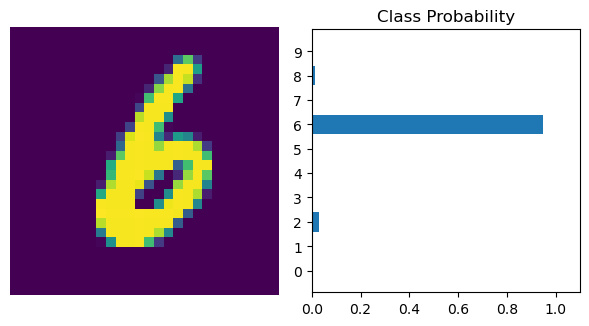

In [67]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
	logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)
plt.show()